In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
from abc import ABC, abstractmethod 
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
class ActivationFunction(Enum):
    ''' Enum of activation functions.
    '''
    Tanh = 0
    Sigmoid = 1
    Sin = 2
    Cos = 3
    Atan = 4

In [3]:
class ActivationFunctionNeuralNetwork(nn.Module):
    '''Activation function of the neural network.
    '''

    def __init__(self, activationFunction=ActivationFunction.Tanh):
        super(ActivationFunctionNeuralNetwork, self).__init__()
        self.activationFunction = activationFunction


    def forward(self, x):
        if self.activationFunction == ActivationFunction.Tanh:
            return torch.tanh(x)

        elif self.activationFunction == ActivationFunction.Sigmoid:
            return torch.sigmoid(x)

        elif self.activationFunction == ActivationFunction.Sin:
            return torch.sin(x)

        elif self.activationFunction == ActivationFunction.Cos:
            return torch.cos(x)

        elif self.activationFunction == ActivationFunction.Atan:
            return torch.atan(x)

In [4]:
class NeuralNet(nn.Module):
    ''' Neural Network used as a mapping function.
        Glorot initialisation.
    '''
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid):
        super(NeuralNet, self).__init__()
        self.layers = []
        for i in range(len(layers) - 2):
            self.layers.append(nn.Linear(in_features=layers[i], out_features=layers[i+1]))
            self.layers.append(ActivationFunctionNeuralNetwork(activationFunction))

        self.layers.append(nn.Linear(in_features=layers[-2], out_features=layers[-1]))
        self.model = nn.Sequential(*self.layers)
        self.model.apply(self._normalInit)

    def _normalInit(self, layer):
        if type(layer) == nn.Linear:
            torch.nn.init.xavier_normal_(layer.weight)


    def partialDerivative(self, input, x, order=1):
        grad = self.model(input)
        for i in range(order):
            grad = torch.autograd.grad(outputs=grad, inputs=x, grad_outputs=torch.ones_like(grad), create_graph=True)[0]
        
        return grad


    @abstractmethod
    def training_loop(self, xBound, yBoundCondition, lossFunction, iterations, *xInt):
        pass


    def train(self, feedDict, lossFunction, iterations):
        # retrieve data
        xInt = torch.tensor(feedDict['xInt'], requires_grad=True).float()
        xBound = torch.tensor(feedDict['xBound'], requires_grad=True).float()
        yBoundCondition = torch.tensor(feedDict['yBoundCondition'])

        if 't' in feedDict:
            t = torch.tensor(feedDict["t"], requires_grad=True).float()
            self.training_loop(xBound, yBoundCondition, lossFunction, iterations, t, xInt)
        else:
            self.training_loop(xBound, yBoundCondition, lossFunction, iterations, xInt)


    def predict(self, feedDict):
        xInt = torch.tensor(feedDict['xInt']).float()
        xBound = torch.tensor(feedDict['xBound']).float()

        outputInt = self.model(xInt)
        outputBound = self.model(xBound)

        return outputInt, outputBound

In [5]:
class NeuralNetGradientDescent(NeuralNet):
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid, **parameters):
        super(NeuralNetGradientDescent, self).__init__(layers, activationFunction)
        self.lr = parameters.get("lr", 0.01)
        self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=self.lr)
        self.training_loss = []

    def training_loop(self, xBound, yBoundCondition, lossFunction, iterations, *xInt): 
        for epoch in range(iterations):
            yInt = self.model( torch.cat(xInt, 1) )
            yBound = self.model(xBound)
            loss = lossFunction(yInt, yBound, yBoundCondition, *xInt)
            self.training_loss.append(loss.item())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if epoch % 1000 == 0:
                print('%d / %d, loss:%.2e' %(epoch, iterations, loss))

In [6]:
class NeuralNetNewtonMethod(NeuralNet):
    def __init__(self, layers, activationFunction=ActivationFunction.Sigmoid, **parameters):
        super(NeuralNetNewtonMethod, self).__init__(layers, activationFunction)

        self.lr = parameters.get('lr', 1)
        self.max_iter = parameters.get('max_iter', 20)
        self.max_eval = parameters.get('max_eval', None)
        self.tolerance_grad = parameters.get('tolerance_grad', 1e-7)
        self.tolerance_change = parameters.get('tolerance_change', 1e-9)
        self.history_size = parameters.get('history_size', 100)
        self.line_search_fn = parameters.get('line_search_fn', None)

        self.optimizer = torch.optim.LBFGS(
            params=self.model.parameters(),
            lr=self.lr,
            max_iter=self.max_iter,
            max_eval=self.max_eval,
            tolerance_grad=self.tolerance_grad,
            tolerance_change=self.tolerance_change,
            history_size=self.history_size,
            line_search_fn=self.line_search_fn
            )
        self.training_loss = []
        
    def training_loop(self, xBound, yBoundCondition, lossFunction, iterations, *xInt):
        for epoch in range(iterations):
            def closure():
                if torch.is_grad_enabled():
                    self.optimizer.zero_grad()
                yInt = self.model(torch.cat(xInt, 1))
                yBound = self.model(xBound)
                loss = lossFunction(yInt, yBound, yBoundCondition, *xInt)
                self.training_loss.append(loss.item())
                if loss.requires_grad:
                    loss.backward()
                return loss
            self.optimizer.step(closure)
            if epoch % 1000 == 0:
                print('%d / %d' %(epoch, iterations))

In [138]:
class GenerateData():
    def __init__(self):
        self.boundaryDomainSize, self.totalBoundaryDomainSize = self._computeBoundaryDomainSize()


    def _computeBoundaryDomainSize(self):
        boundaryDomainSize = []
        totalBoundaryDomainSize = 0
        for i in range(len(self.spaceDomain)):
            boundaryDomainSize.append(1)
            for j in range(len(self.spaceDomain)):
                if j != i:
                    boundaryDomainSize[i] = boundaryDomainSize[i] * (self.spaceDomain[j][1] - self.spaceDomain[j][0])
            totalBoundaryDomainSize = totalBoundaryDomainSize + 2 * boundaryDomainSize[i]
        
        return boundaryDomainSize, totalBoundaryDomainSize


    def _sampleInteriorX(self, pointCount):
            ''' If time involved, it is treated as an extra dimension: no change for interior sampling.
            '''

            xInt = []
            for i in range(len(self.spaceDomain)):
                xInt.append(np.random.uniform(low=self.spaceDomain[i][0], high=self.spaceDomain[i][1], size=(pointCount, 1)))
            
            return xInt


    def _sampleBoundaryX(self, pointCount):
            ''' Sample points on the boundaries of the space domain only.
            '''
            if pointCount < 2 * len(self.spaceDomain):
                pointCount = 2 * len(self.spaceDomain)

            xBound = []

            # iterate over dimensions
            for i in range(len(self.spaceDomain)):
                xBound.append(np.empty((0, 1), dtype=np.float64))

                # iterate over boundaries
                for j in range(len(self.spaceDomain)):
                    for bound in self.spaceDomain[j]:
                        newPoints = max(int(pointCount * self.boundaryDomainSize[j] / self.totalBoundaryDomainSize), 1)
                        if j == i:
                            newX = np.full((newPoints, 1), bound, dtype=np.float64)
                        else:
                            newX = np.random.uniform(low=self.spaceDomain[j][0], high=self.spaceDomain[j][1], size=(newPoints, 1))
                        xBound[i] = np.concatenate((xBound[i], newX))

            return xBound

In [162]:
class GenerateSpaceData(GenerateData):
    def __init__(self, domain):
        self.spaceDomain = domain
        GenerateData.__init__(self)

    def sampleInteriorX(self, pointCount):
        return self._sampleInteriorX(pointCount)

    def sampleBoundaryX(self, pointCount):
        return self._sampleBoundaryX(pointCount)


class GenerateDataWithTime(GenerateData):
    def __init__(self, domain):
        self.timeDomain = domain[0]
        self.spaceDomain = domain[1:]
        GenerateData.__init__(self)
        self.tInitial = self.timeDomain[0]
        self.tFinal = self.timeDomain[1]
        self.timeSteps = 10

    
    def sampleBoundaryX(self, pointCount):
        xBound = self.sampleInteriorX( int(pointCount / self.timeSteps) )
        terminalTime = self.tFinal * np.ones_like(xBound[0])
        return [terminalTime] + xBound

    def sampleInteriorX(self, pointCount):
        return self._sampleInteriorX(self.timeSteps * pointCount)

    def sampleTime(self, pointPerTimeStep):
        time = np.zeros(shape=(pointPerTimeStep * self.timeSteps, 1))

        for i in range(self.timeSteps):
            time[i*pointPerTimeStep : (i+1)*pointPerTimeStep, :] = self.tInitial + i * (self.tFinal - self.tInitial) / self.timeSteps

        return [time]

In [163]:
dataGen = GenerateDataWithTime([(0, 1), (0, 1), (0,1)])
dataGen.sampleBoundaryX(10)

[array([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), array([[0.92055822],
        [0.23728666],
        [0.58736791],
        [0.15124269],
        [0.72799844],
        [0.61843641],
        [0.64788916],
        [0.94541934],
        [0.31760598],
        [0.30201863]]), array([[0.54506178],
        [0.7802003 ],
        [0.59342554],
        [0.15725699],
        [0.53328612],
        [0.34041235],
        [0.78114511],
        [0.45851266],
        [0.71579777],
        [0.40765274]])]

In [164]:
class PDENeuralNetwork():
    def __init__(self, network, domain, terminalCondition):
        self.network = network
        self.domain = domain
        self.terminalCondition = terminalCondition


    def sampleData(self, interiorPointCount, boundaryPointCount):
        feedDict = {}

        if self.terminalCondition:
            dataGen = GenerateDataWithTime(domain=self.domain)
            t = dataGen.sampleTime(interiorPointCount)
            xInt = dataGen.sampleInteriorX(interiorPointCount)
            feedDict['t'] = np.array(t)[:,:,0].T
        else:
            dataGen = GenerateSpaceData(domain=self.domain)
            xInt = dataGen.sampleInteriorX(interiorPointCount)

        xBound = dataGen.sampleBoundaryX(boundaryPointCount)
        yBoundCondition= self.boundaryCondition(xBound)

        feedDict['xInt'] = np.array(xInt)[:,:,0].T
        feedDict['xBound'] = np.array(xBound)[:,:,0].T
        feedDict['yBoundCondition'] = np.array(yBoundCondition)

        return feedDict


    def train(self, interiorPointCount, boundaryPointCount, lossWeight, iterations):
        feedDict = self.sampleData(interiorPointCount=interiorPointCount, boundaryPointCount=boundaryPointCount)

        self.network.train(feedDict, self.defaultLoss, iterations)


    def predict(self, interiorPointCount, boundaryPointCount, lossWeight):
        feedDict = self.sampleData(interiorPointCount=interiorPointCount, boundaryPointCount=boundaryPointCount)

        predictionInterior, predictionBound = self.network.predict(feedDict)

        # Analytical Solution
        self.analyticalInterior = self.analyticalSolution(feedDict['xInt'])
        self.analyticalBound = self.analyticalSolution(feedDict['xBound'])

        # Compute L2 error (not sure the sum of interior and boundary is what we need...)
        errorInt = np.sqrt(np.sum((self.analyticalInterior - predictionInterior.detach().numpy()) ** 2))
        errorBound = np.sqrt(np.sum((self.analyticalBound - predictionBound.detach().numpy()) ** 2))

        return errorInt + errorBound


    def defaultLoss(self, yInt, yBound, yBoundCondition, *xInt):
        # put that in the parent class
        lossInt, lossBound = self.computeLossTerms(self.domain, yInt, yBound, yBoundCondition, *xInt)

        return self.lossWeight * lossInt + (1 - self.lossWeight) * lossBound

    @abstractmethod
    def computeLossTerms(self, domain, yInt, yBound, yBoundCondition, *xInt):
        pass

In [165]:
class HamiltonJacobiBellman(PDENeuralNetwork):
    def __init__(self, network, domain, beta=1):
        PDENeuralNetwork.__init__(self, network=network, domain=domain, terminalCondition=True)
        self.beta = beta
        self.T = domain[0][1]

    def computeLossTerms(self, domain, yInt, yBound, yBoundCondition, t, xInt):
        input = torch.cat([t, xInt], 1)
        derivativeTime = network.partialDerivative(input=input, x=t, order=1)
        derivativeSpace = network.partialDerivative(input=input, x=xInt, order=1)

        equation = (
            derivativeTime 
            - 1 / (2 * self.beta) * torch.einsum('ni,nij,njk,nk->n', derivativeSpace, self.g(xInt), self.g(xInt), derivativeSpace).reshape(-1,1)
            + torch.einsum('ij,ij->i', derivativeSpace, self.f(xInt) ).reshape(-1,1)
            + self.l(xInt).reshape(-1,1)
            )

        lossInt = torch.mean(torch.square(equation))
        lossBound = torch.mean(torch.square(yBound - yBoundCondition))

        return lossInt, lossBound


    @abstractmethod
    def f(self, x):
        pass


    @abstractmethod    
    def g(self, x):
        pass


    @abstractmethod
    def l(self, x):
        pass

In [166]:
class VanDerPolOscillator(HamiltonJacobiBellman):
    def __init__(self, lossWeight, network=None):
        domain = [(0, 1), (-1, 1), (-1, 1)]
        HamiltonJacobiBellman.__init__(self, network=network, domain=domain,)
        self.lossWeight = lossWeight

    def f(self, x):
        x1 = x[:, 0].reshape(-1,1)
        x2 = x[:, 1].reshape(-1,1)
        return torch.cat([x2, -x1 + x2 * (1 - x1**2)], 1)

    def g(self, x):
        n = x.shape[0]
        return torch.stack(n * [torch.eye(2)])

    def l(self, x):
        return torch.norm(x, dim=1)
        
    def boundaryCondition(self, x):
        return 0

In [167]:
class LaplaceBase(PDENeuralNetwork):
    def __init__(self, network, domain, terminalCondition=False):
        PDENeuralNetwork.__init__(self, domain=domain, network=network, terminalCondition=terminalCondition)


    def computeLossTerms(self, domain, yInt, yBound, yBoundCondition, xInt):
        gradients = network.partialDerivative(input=xInt, x=xInt, order=2)
        lossInt = torch.mean(torch.square(gradients))
        lossBound = torch.mean(torch.square(yBound - yBoundCondition))

        return lossInt, lossBound

    @abstractmethod
    def boundaryCondition(self, x):
        pass

In [168]:
class Laplace_2d(LaplaceBase):
    def __init__(self, frequency, lossWeight, network=None):
        domain = [(0, 1), (0, 1)]
        LaplaceBase.__init__(self, network=network, domain=domain)
        self.frequency = frequency
        self.lossWeight = lossWeight


    def analyticalSolution(self, x):
        return np.exp(-x[0] * self.frequency) * np.sin(x[1] * self.frequency)


    def boundaryCondition(self, x):
        return np.exp(-x[0] * self.frequency) * np.sin(x[1] * self.frequency)

# Van der Pol oscillator example

In [169]:
interiorPointCount = 100
boundaryPointCount = 100
lossWeight = 0.5
iterations = 3000

In [170]:
network = NeuralNetGradientDescent([3, 10, 1], ActivationFunction.Sigmoid, **{'lr': 0.01})
vanDerPol = VanDerPolOscillator(lossWeight=lossWeight, network=network)

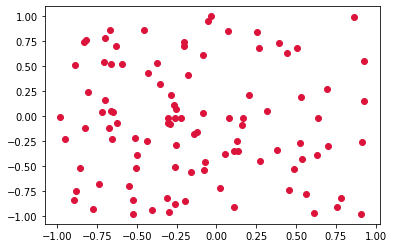

In [171]:
data = vanDerPol.sampleData(interiorPointCount, boundaryPointCount)
xInt = torch.from_numpy(data['xInt']).float()
xBound = torch.from_numpy(data['xBound']).float()
plt.scatter( xBound[:,1], xBound[:,2], color='crimson', label='Terminal condition' )
#plt.scatter( xInt[:,0], xInt[:,1], color='royalblue', label='Dynamics before end' )
#plt.legend();

In [172]:
xBound.shape

torch.Size([100, 3])

In [173]:
vanDerPol.train(interiorPointCount, boundaryPointCount, lossWeight, iterations)

0 / 3000, loss:7.78e-01
1000 / 3000, loss:3.15e-02
2000 / 3000, loss:1.27e-02


In [174]:
def plot_solution(t):
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)

    X, Y = np.meshgrid(x, y)
    space = torch.tensor([X, Y]).T.float()

    # at time t=1 the solution is 0
    time = t * torch.ones(size=(50,50,1))
    Z = vanDerPol.network.model( torch.cat( [time, space], 2 )).T.float().detach().numpy()[:,:,0]
    fig = plt.figure(figsize=(10, 7))
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_zlim(0,1);

In [175]:
time_factor=widgets.FloatSlider(value=0, min=0, max=1, step=0.1, description='t')

ui = time_factor
out = widgets.interactive_output(plot_solution, {'t': time_factor})

display(ui, out)

FloatSlider(value=0.0, description='t', max=1.0)

Output()

# Laplace example

In [187]:
interiorPointCount = 100
boundaryPointCount = 100
lossWeight = 0.001
iterations = 3000
frequency = 2 * np.pi

In [188]:
network = NeuralNetGradientDescent([2, 10, 1], ActivationFunction.Sigmoid, **{'lr': 0.01})
laplace = Laplace_2d(frequency=frequency, lossWeight=lossWeight, network=network)

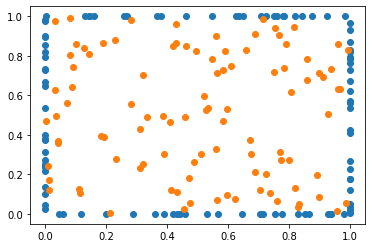

In [189]:
data = laplace.sampleData(interiorPointCount, boundaryPointCount)
xInt = torch.from_numpy(data['xInt']).float()
xBound = torch.from_numpy(data['xBound']).float()
plt.scatter( xBound[:,0], xBound[:,1] )
plt.scatter( xInt[:,0], xInt[:,1] );

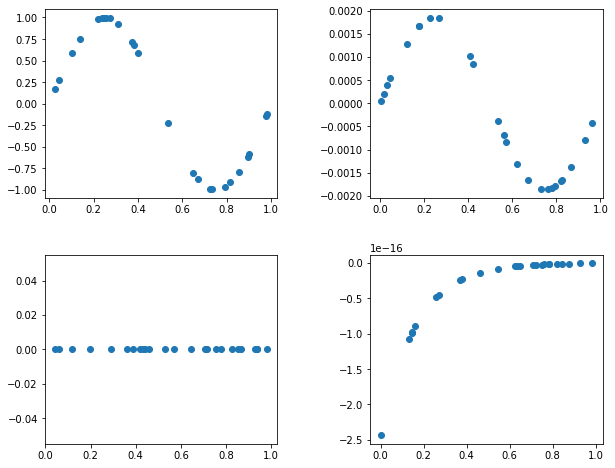

In [190]:
fig, axs = plt.subplots(2, 2, figsize=(10,8))
axs = axs.flatten()
for ax, idx, coord in zip(axs, range(4), [1,1,0,0]):
    ax.scatter( data['xBound'][idx*25 : (idx+1)*25, coord], data['yBoundCondition'][idx*25 : (idx+1)*25] )
plt.subplots_adjust(wspace=0.4, hspace=0.3);

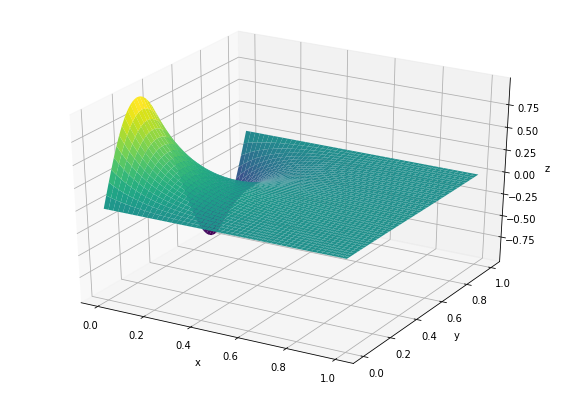

In [191]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = laplace.analyticalSolution([X, Y])

fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

## Adam optimizer

In [192]:
laplace.train(interiorPointCount, boundaryPointCount, lossWeight, iterations)

0 / 3000, loss:3.34e-01
1000 / 3000, loss:7.79e-02
2000 / 3000, loss:2.93e-02


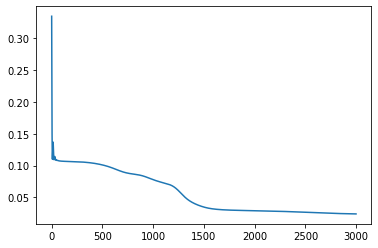

In [193]:
plt.plot( laplace.network.training_loss );

In [194]:
laplace.predict(interiorPointCount, boundaryPointCount, lossWeight)

7.3786652972110485

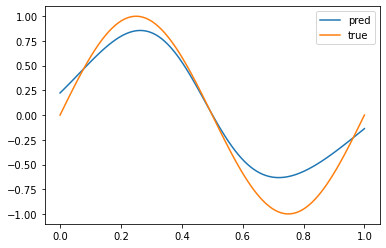

In [195]:
x0 = 0
plt.plot(np.linspace(0, 1, 100), laplace.network.model(torch.tensor([x0 * np.ones(100), np.linspace(0, 1, 100)]).T.float()).detach(), label='pred')
plt.plot(np.linspace(0, 1, 100), laplace.analyticalSolution(torch.tensor([x0 * np.ones(100), np.linspace(0, 1, 100)])), label='true')
plt.legend();

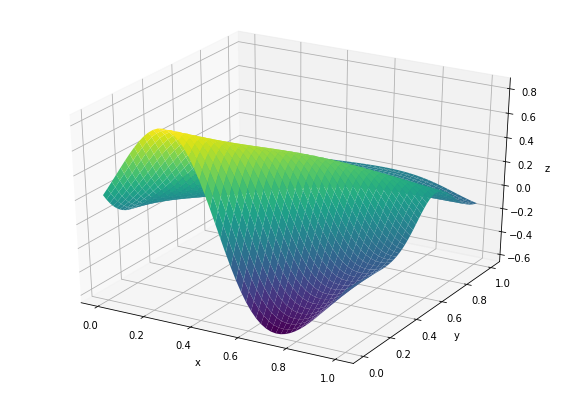

In [196]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = laplace.network.model(torch.tensor([X, Y]).T.float()).detach().numpy()[:,:,0]
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

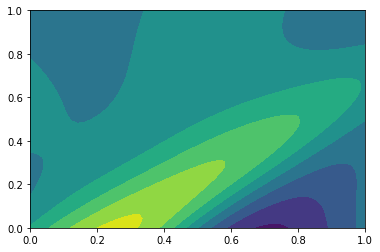

In [197]:
fig, ax = plt.subplots()
ax.contourf(X, Y, Z);

In [198]:
# can we plot the error?

## LBFGS optimizer

In [199]:
network = NeuralNetNewtonMethod([2, 10, 1], ActivationFunction.Sigmoid, **{'max_iter': 40})
laplace = Laplace_2d(frequency=frequency, lossWeight=lossWeight, network=network)
laplace.train(interiorPointCount, boundaryPointCount, lossWeight, iterations=10)

0 / 10


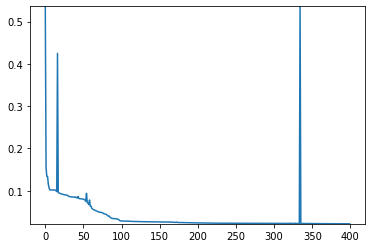

In [200]:
plt.plot( laplace.network.training_loss );
plt.ylim( laplace.network.training_loss[-1], laplace.network.training_loss[0]);

In [201]:
laplace.predict(interiorPointCount, boundaryPointCount, lossWeight)

8.32529933509098

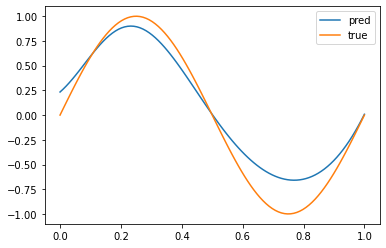

In [202]:
plt.plot(np.linspace(0, 1, 100), laplace.network.model(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)]).T.float()).detach(), label='pred')
plt.plot(np.linspace(0, 1, 100), laplace.analyticalSolution(torch.tensor([np.zeros(100), np.linspace(0, 1, 100)])), label='true')
plt.legend();

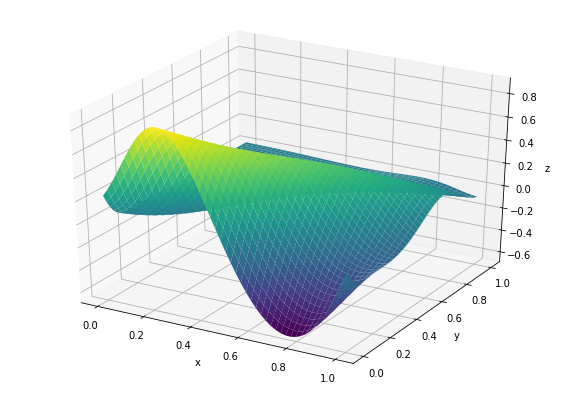

In [203]:
x = np.linspace(0, 1, 50)
y = np.linspace(0, 1, 50)

X, Y = np.meshgrid(x, y)
Z = laplace.network.model(torch.tensor([X, Y]).T.float()).detach().numpy()[:,:,0]
fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');

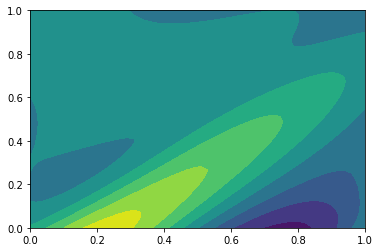

In [204]:
fig, ax = plt.subplots()
ax.contourf(X, Y, Z);